### Great References to study deeper:

- David Silver (DeepMind)
http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html
- Richard Sutton
http://incompleteideas.net/book/the-book-2nd.html


In [2]:
# In WinEluk use environment "cvision"
# In Valta use root environment

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.autograd import Variable

print('torch version:',torch.__version__)
use_cuda = torch.cuda.is_available()
print('Cuda: ', use_cuda)

torch version: 0.4.0
Cuda:  True


## CartPole-v0: Experience Replay + "Q-learning" + Neural Net (2 layers)
- **GOAL**: be able to keep the pole for >195 steps, that is, reward>195

- Ref: hhttps://arxiv.org/abs/1312.5602
      
- **PROBLEM** of previous implementation:
-   a) samples are highly correlated --> solved with experience replay (OK)
-   b) non-stationary distribution -->  
- **SOLUTION**: a buffer of past experience (works like a batch), so that the learning is made based on the history

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

*** Episode 0 ***                 
 Avg.Reward [last 50]: 0.22, [last 100]: 0.11, [all]: 11.00                
 epsilon: 0.88, cont_steps= 11
Elapsed time:  00:00:00

*** Episode 50 ***                 
 Avg.Reward [last 50]: 112.76, [last 100]: 56.49, [all]: 110.76                
 epsilon: 0.02, cont_steps= 5649
Elapsed time:  00:00:11

*** Episode 100 ***                 
 Avg.Reward [last 50]: 189.28, [last 100]: 151.02, [all]: 149.63                
 epsilon: 0.02, cont_steps= 15113
Elapsed time:  00:00:34

*** Episode 150 ***                 
 Avg.Reward [last 50]: 191.22, [last 100]: 190.25, [all]: 163.40                
 epsilon: 0.02, cont_steps= 24674
Elapsed time:  00:00:58

*** Episode 200 ***                 
 Avg.Reward [last 50]: 198.02, [last 100]: 194.62, [all]: 172.01                
 epsilon: 0.02, cont_steps= 34575
Elapsed time:  00:01:17
SOLVED! After 205 episodes

*

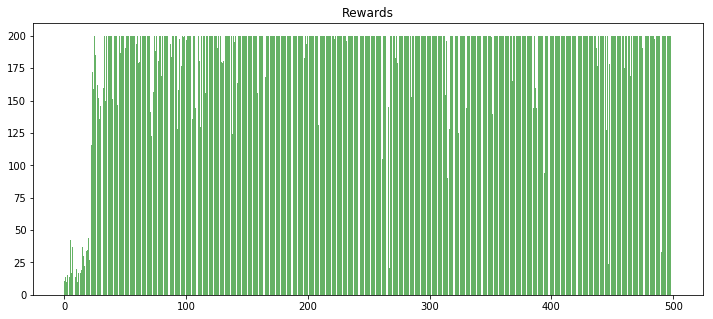

In [44]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
import time

import matplotlib.pyplot as plt
%matplotlib inline

# Debug mode
debug = False

# Set CPU or GPU device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu") 

# Set Gym environment
env = gym.make('CartPole-v0')

# Set seeds
seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

# PARAMS
num_episodes = 500
score_goal = 195 # official

gamma = 0.99
my_lr = 0.02
nhidden = 64

replay_mem_size = 50000
batch_size = 32

egreedy = 0.9
egreedy_final = 0.02
egreedy_decay = 500

# e-Greedy strategy
def calc_epsilon(nsteps):
    epsilon = egreedy_final + \
       (egreedy - egreedy_final)*math.exp(-1.*nsteps/egreedy_decay) 
    return epsilon

class ExperienceReplay():
    # works like a buffer of past experience
    def __init__(self, capacity):
        self.capacity = capacity # maximum size of memory
        self.memory = [] # list of states
        self.position = 0 # keep track where to add the new sample
 
    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)
        
        if self.position >= len(self.memory):
            self.memory.append(transition) # keep adding while memory is no full
        else:
            self.memory[self.position] = transition # add state at "position"
        
        self.position = ( self.position + 1 ) % self.capacity # it works as a cuclic counter
        
        
    def sample(self, batch_size):
        # zip(*list) --> # this will return the states grouped by each variable
        # print([i for i in zip([[1,2,3],[4,5,6]])])
        # [([1, 2, 3],), ([4, 5, 6],)]
        # print([i for i in zip(*[[1,2,3],[4,5,6]])])
        # [(1, 4), (2, 5), (3, 6)]
        
        # random.sample(self.memory, batch_size) --> return random samples of states
        
        return zip(*random.sample(self.memory, batch_size)) 
        # If state=[s,a,s',r,done]
        # zip(*) will return:
        # [(s1,s2,s3),(a1,a2,a3),(s'1,s'2,s'3),(done1,done2,done3)] 
        
        
    def __len__(self):
        return len(self.memory)

# NEURAL NETWORK
n_inputs = env.observation_space.shape[0] 
n_outputs = env.action_space.n

# 1) Define the NN architecture
class NeuralNet(nn.Module): # self inherits the class nn.Module
    def __init__(self):
        super(NeuralNet, self).__init__() # Call parent's init
        self.linear1 = nn.Linear(n_inputs,nhidden) # input
        #self.linear2 = nn.Linear(nhidden[0],nhidden[1]) # layer 1
        self.linear2 = nn.Linear(nhidden,n_outputs) # layer 2
        
        self.activation = nn.Tanh()
        #self.activation = nn.ReLU()
        
    def forward(self,x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)
        #output2 = self.activation(output2)
        #output3 = self.linear3(output2)
        
        return output2
    
# 2) Define the NN-agent
class Qnet_agent():
    # 1) Init
    def __init__(self):
        # a) Architecture
        self.nn = NeuralNet().to(device)
        # b) Loss
        self.loss = nn.MSELoss() # linear regression
        # c) Optim
        self.optimizer = optim.Adam(params=self.nn.parameters(),lr=my_lr)
        
    # 2) Action
    def select_action(self,state,epsilon):
        # e-greedy with Exploit x Explore trade-off
        randx = torch.rand(1)[0]
        
        if randx > epsilon:
            # Exploit
            with torch.no_grad(): # more efficient than detach()
                state = torch.Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action_index = torch.max(action_from_nn,0)[1] # 1 for the index
                action = action_index.item()
                
                if debug:
                    print('--> Exploit action_from_nn[',action_from_nn,'] action:',action)
        else:
            # Explore
            action = env.action_space.sample()
            if debug:
                print('--> Explore: action:',action)
            
        return action
    
    # 3) Optimize (UPDATED FOR REPLAY)
    #def optimize(self,state,action,new_state,reward,done):
    def optimize(self):
        # only update with have memory enough to sample
        if (len(memory) < batch_size):
            return
        # Get a sample from memory
        state,action,new_state,reward,done = memory.sample(batch_size)
        
        # Convert to appropriate tensors
        state = torch.Tensor(state).to(device) # Convert to tensor
        new_state = torch.Tensor(new_state).to(device)
        #reward = torch.Tensor([reward]).to(device) # since others are list, reward has to be in list format
        reward = torch.Tensor(reward).to(device) # reward is a list now!
        # We haver to now convert action and reward to tensor!
        action = torch.LongTensor(action).to(device) # for integers
        done = torch.Tensor(done).to(device)
        
        #if done: --> done is a vector... so does not make sense to check like this...
        #         --> we will use a little trick "(1-done)" to control this!
        #    target_value = reward # episode is completed
        #else:
            ## Bellman's equation (- Traditional way -)
            # Q[state,action] = reward + gamma*torch.max(Q[new_state])
        
        # We will use NNet instead to Approx Q (- New way -)
        new_state_values = self.nn(new_state).detach() # leave the grad
        #max_new_state_values = torch.max(new_state_values)
        max_new_state_values = torch.max(new_state_values,1)[0] # max of each column
        #target_value = reward + gamma*max_new_state_values
        # (1-done) is use as a trick. If done=1 --> target_value = reward
        target_value = reward + (1-done)*gamma*max_new_state_values

        ## Q-learning: use prediction-error to update Q
        # (-- Traditional way --)
        # Q[state, action] = (1 - lr) * Q[state, action] \
        #    + lr * (reward + gamma * torch.max(Q[new_state]))
        
        # (-- New way --)    
        # Current state
        #predicted_value = self.nn(state)[action] # here we carry grad because it will update
        # (version for vector: details on how to set the dimensions!)
    
        #print('actions:',action)
        #print('output net:',self.nn(state))
        predicted_value = self.nn(state).gather(1,action.unsqueeze(1)).squeeze(1)
        #print('reward predictions:',predicted_value)
        
        # Prediction error
        loss = self.loss(predicted_value,target_value)
        # Backprop
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step() # update params
        

# 3) RL part
memory = ExperienceReplay(replay_mem_size)

agent = Qnet_agent()
steps_total = []
all_solved_nepisodes = []
solved = False
cont_steps = 0
tic = time.time()
for i_episode in range(num_episodes):
    
    state = env.reset()
    step = 0

    while True:
        
        step += 1
        
        cont_steps += 1 # will keep across episodes
        epsilon = calc_epsilon(cont_steps) 
        
        # Action is selected
        action = agent.select_action(state,epsilon)
        
        # Next environment
        new_state, reward, done, info = env.step(action)
        # States: [cart position,cart velocity,pole angle, pole velocity]
        
        # Update NNet
        #agent.optimize(state,action,new_state,reward,done)
        memory.push(state, action, new_state, reward, done)
        agent.optimize()
        
        if debug:
            print('Step#%d: %s, state:%s'%(step,action,new_state))
            #print(info)
            env.render()
            input("")
        
        # Prepare next iteration
        state = new_state
        
        if done:
            steps_total.append(step)
            #print("Episode finished after %i steps" % step )
            
            avgReward100 = sum(steps_total[-100:])/100
            
            if avgReward100 > score_goal and not solved:
                print('SOLVED! After %d episodes' %(i_episode))
                all_solved_nepisodes.append(i_episode)
                solved = True
                break
            
            # Better reporting
            interval = 50
            if i_episode % interval == 0:
                print('\n*** Episode %i *** \
                \n Avg.Reward [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f\
                \n epsilon: %.2f, cont_steps= %d'%
                      (i_episode, interval,
                      sum(steps_total[-interval:])/interval,
                      avgReward100,
                      sum(steps_total)/len(steps_total),
                       epsilon, cont_steps
                      ))
                toc = time.time()
                print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(toc-tic)))
            
            break
        

print("Average reward: %.2f" % (sum(steps_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
print("#Episodes until SOLVE: ", all_solved_nepisodes[0])

plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green')
plt.show()

env.close()
env.env.close()
